## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


## Base CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=8
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:03<00:00, 43307516.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                 model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                 prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

base_capsnet_cifar10_model.name = 'base_capsnet_cifar10_model'
base_capsnet_cifar10_model = base_capsnet_cifar10_model.to(device)
base_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

### Training

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  base_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/10 04:56:51 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5771, Top 1 Acc=7.81, Top 5 Acc=37.50
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5771, Top 1 Acc=7.81, Top 5 Acc=37.50
02/10 04:56:55 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4532, Top 1 Acc=32.88, Top 5 Acc=78.75
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4532, Top 1 Acc=32.88, Top 5 Acc=78.75
02/10 04:57:00 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4240, Top 1 Acc=38.01, Top 5 Acc=82.97
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4240, Top 1 Acc=38.01, Top 5 Acc=82.97
02/10 04:57:04 PM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4054, Top 1 Acc=41.17, Top 5 Acc=85.36
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.405

CPU times: user 27min, sys: 1min 23s, total: 28min 23s
Wall time: 28min 22s


### Plots for losses and accuracies

In [ ]:
base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = base_capsnet_cifar10_model['epoch_accuracy']

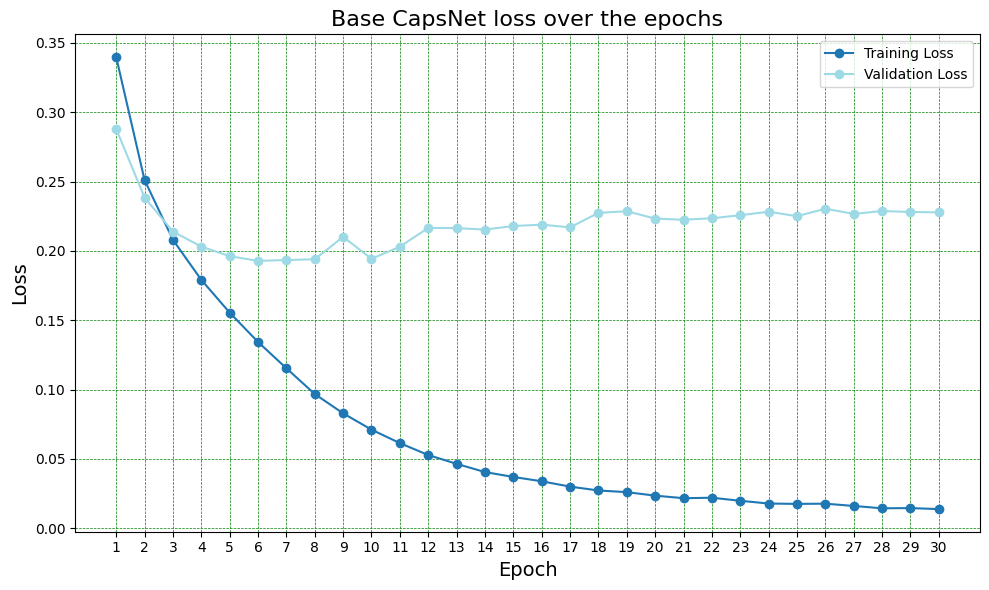

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Base CapsNet loss over the epochs')

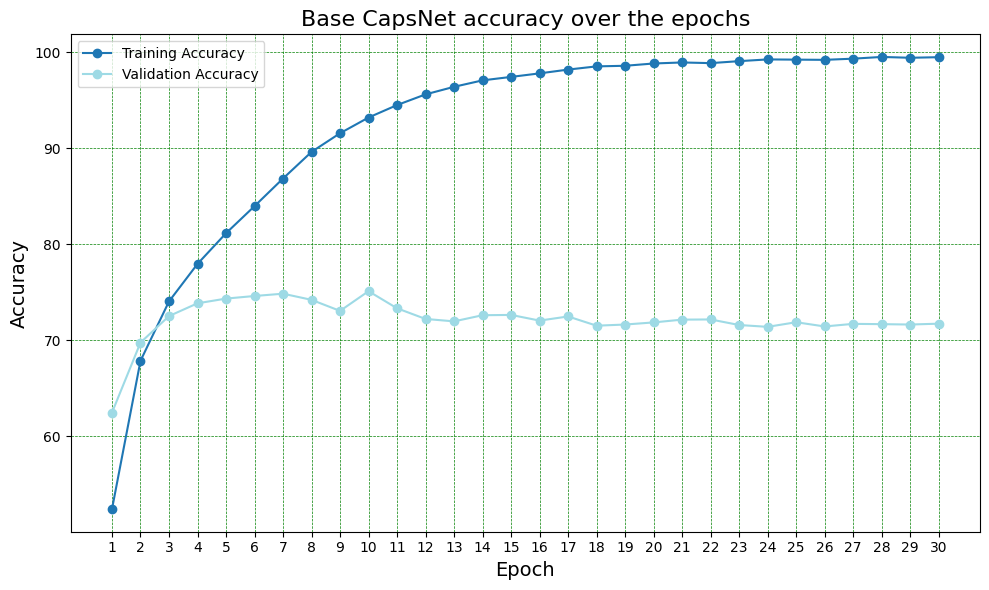

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Base CapsNet accuracy over the epochs')

### Training with CCM loss

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=8
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      calc_ccm=True,
                                                      device=device)

02/10 05:28:10 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.0397, Top 1 Acc=95.31, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.0397, Top 1 Acc=95.31, Top 5 Acc=100.00
02/10 05:28:14 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.0391, Top 1 Acc=95.91, Top 5 Acc=99.98
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.0391, Top 1 Acc=95.91, Top 5 Acc=99.98
02/10 05:28:19 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.0414, Top 1 Acc=95.69, Top 5 Acc=99.96
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.0414, Top 1 Acc=95.69, Top 5 Acc=99.96
02/10 05:28:23 PM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(192/782), Loss=0.0424, Top 1 Acc=95.38, Top 5 Acc=99.96
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoc

Checkpoint restart

In [ ]:
checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_ccm_model_Epoch17_of_30.pt'

best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  base_capsnet_cifar10_ccm_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  calc_ccm=True,
                                                  device=device,
                                                  checkpoint_file=checkpoint_file)

02/10 06:54:48 PM | base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(0/782), Loss=0.0036, Top 1 Acc=98.44, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(0/782), Loss=0.0036, Top 1 Acc=98.44, Top 5 Acc=100.00
02/10 06:54:52 PM | base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(64/782), Loss=-0.0001, Top 1 Acc=99.38, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(64/782), Loss=-0.0001, Top 1 Acc=99.38, Top 5 Acc=100.00
02/10 06:54:56 PM | base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(128/782), Loss=-0.0010, Top 1 Acc=99.59, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(128/782), Loss=-0.0010, Top 1 Acc=99.59, Top 5 Acc=100.00
02/10 06:55:02 PM | base_capsnet_cifar10_ccm_model Training - Epoch=18, Iteration=(192/782), Loss=-0.0008, Top 1 Acc=99.50, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_mode

### CCM and CI score calculation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=8
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

Extract Correlation Coefficient Matrix

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_conv_layers = 4
layer_ccm_list = [ [] for _ in range(n_conv_layers) ]
layer_mean_ccm_list = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            _, batch_ccm = ccmp.calc_ccm_loss(batch_feature_maps)
            layer_ccm_list[indx].append(batch_ccm.detach().cpu())

        torch.cuda.empty_cache()

for i in range(n_conv_layers):
    layer_mean_ccm_list.append(torch.mean(torch.stack(layer_ccm_list[i]), dim=0))

ccmp.save_ccm(layer_mean_ccm_list, CIFAR10_TRAIN_DIR, base_capsnet_cifar10_ccm_model.name+'_ccm')

base_capsnet_cifar10_ccm_model_ccm saved
CPU times: user 19.3 s, sys: 3.3 s, total: 22.6 s
Wall time: 23.3 s


Channel Importance Scores

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_conv_layers = 4
layer_ci_list = [ [] for _ in range(n_conv_layers) ]

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            batch_ci_score = ccmp.ci_score(batch_feature_maps)
            layer_ci_list[indx].append(batch_ci_score.detach().cpu().numpy())

        torch.cuda.empty_cache()

    layer_mean_ci_list = []

    for i in range(n_conv_layers):
        layer_mean_ci_list.append(np.mean(layer_ci_list[i], axis=0))

    np.save(CIFAR10_TRAIN_DIR+base_capsnet_cifar10_ccm_model.name+'_ci_scores.npy', np.asarray(layer_mean_ci_list, dtype=object))

CPU times: user 8min 19s, sys: 3.35 s, total: 8min 22s
Wall time: 8min 25s


### Pruning

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=8
prim_caps_dim=12
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
pretrained_base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                model_conv_config=model_conv_config,
                                                                prim_caps_channels=prim_caps_channels,
                                                                prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

pretrained_base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

pretrained_base_capsnet_cifar10_ccm_model = pretrained_base_capsnet_cifar10_ccm_model.to(device)
pretrained_base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)

In [ ]:
layers_to_prune_dict = {'conv_layer_1':0,
                        'conv_layer_2':1,
                        'conv_layer_3':2,
                        'primary_caps':3 }

base_capsnet_cifar10_ccm_model_ci_scores = np.load(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ccm_model_ci_scores.npy', allow_pickle=True)
# base_capsnet_cifar10_ccm_model_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm_model_ccm')

#### 12.5% Pruning

In [ ]:
prune_threshold = 0.125

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_12pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_12pc_base_capsnet_cifar10_model.name = 'pruned_12pc_base_capsnet_cifar10_model'
pruned_12pc_base_capsnet_cifar10_model = pruned_12pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(36, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(84, 84, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_12pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_12pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/10 07:16:57 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6825, Top 1 Acc=12.50, Top 5 Acc=48.44
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6825, Top 1 Acc=12.50, Top 5 Acc=48.44
02/10 07:17:02 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4449, Top 1 Acc=37.93, Top 5 Acc=80.24
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4449, Top 1 Acc=37.93, Top 5 Acc=80.24
02/10 07:17:06 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3996, Top 1 Acc=45.48, Top 5 Acc=85.57
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3996, Top 1 Acc=45.48, Top 5 Acc=85.57
02/10 07:17:12 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3725, Top 1 Acc=49.86, Top 5 Acc=87.95
INFO:

CPU times: user 30min 20s, sys: 1min 32s, total: 31min 52s
Wall time: 32min 15s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_accuracy']

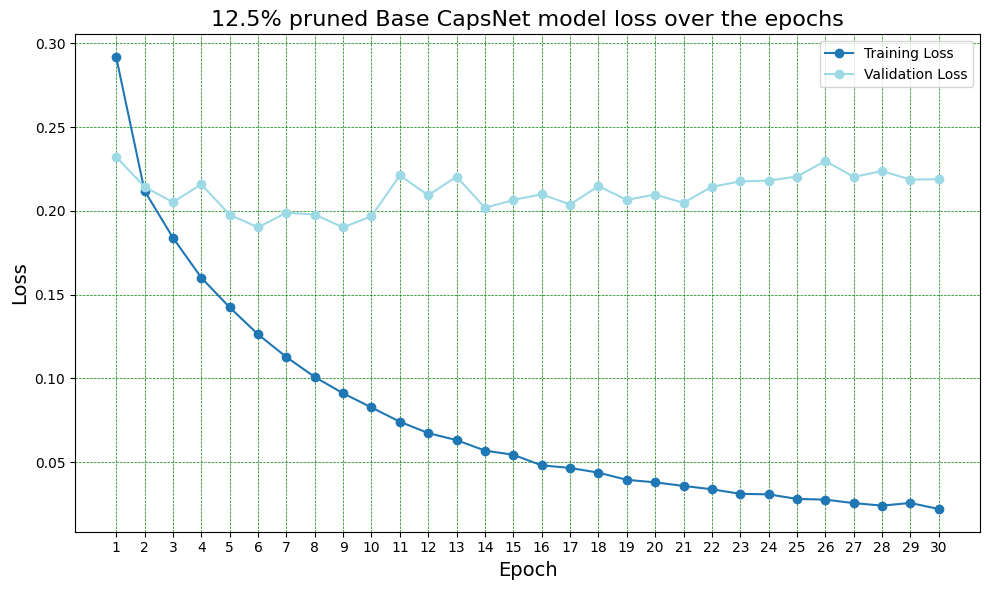

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '12.5% pruned Base CapsNet model loss over the epochs')

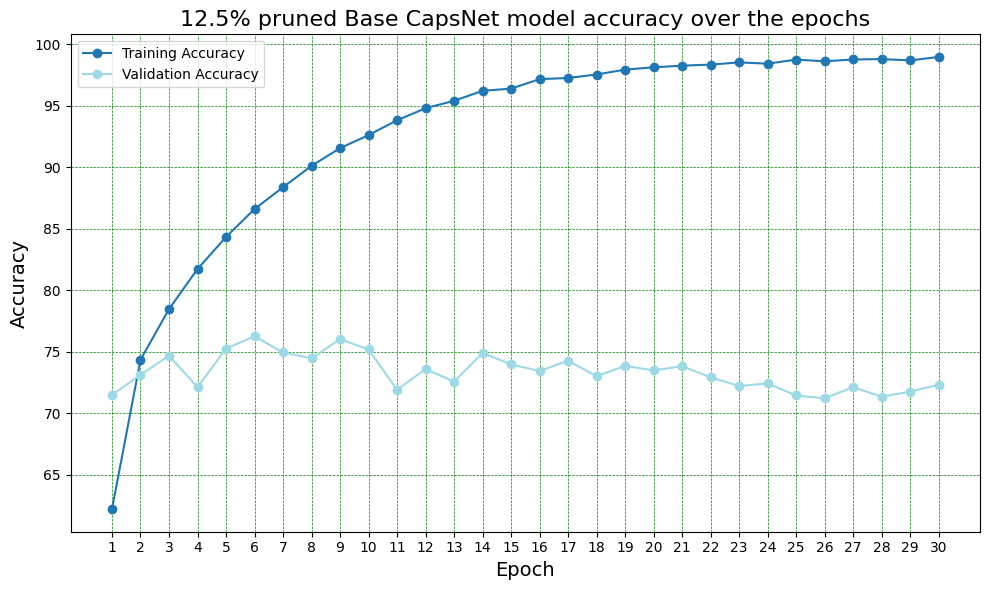

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '12.5% pruned Base CapsNet model accuracy over the epochs')

#### 25% Pruning

In [ ]:
prune_threshold = 0.25

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_25pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_25pc_base_capsnet_cifar10_model.name = 'pruned_25pc_base_capsnet_cifar10_model'
pruned_25pc_base_capsnet_cifar10_model = pruned_25pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_25pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_25pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/10 07:49:14 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5990, Top 1 Acc=7.81, Top 5 Acc=60.94
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5990, Top 1 Acc=7.81, Top 5 Acc=60.94
02/10 07:49:19 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4150, Top 1 Acc=41.63, Top 5 Acc=84.40
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4150, Top 1 Acc=41.63, Top 5 Acc=84.40
02/10 07:49:24 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3745, Top 1 Acc=48.78, Top 5 Acc=88.21
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3745, Top 1 Acc=48.78, Top 5 Acc=88.21
02/10 07:49:29 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3525, Top 1 Acc=52.66, Top 5 Acc=89.75
INFO:ca

CPU times: user 29min 7s, sys: 1min 32s, total: 30min 40s
Wall time: 30min 54s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_accuracy']

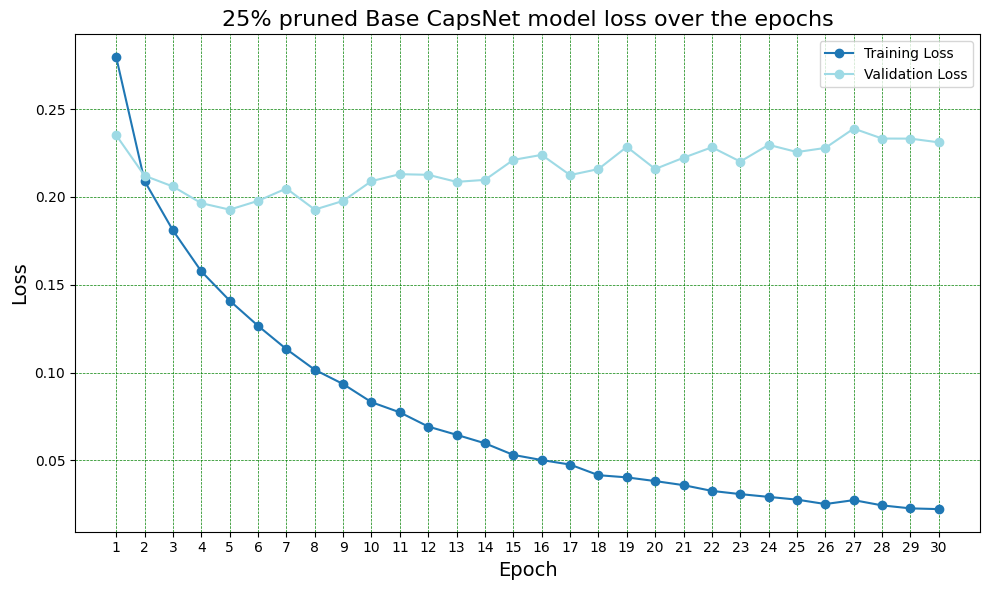

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% pruned Base CapsNet model loss over the epochs')

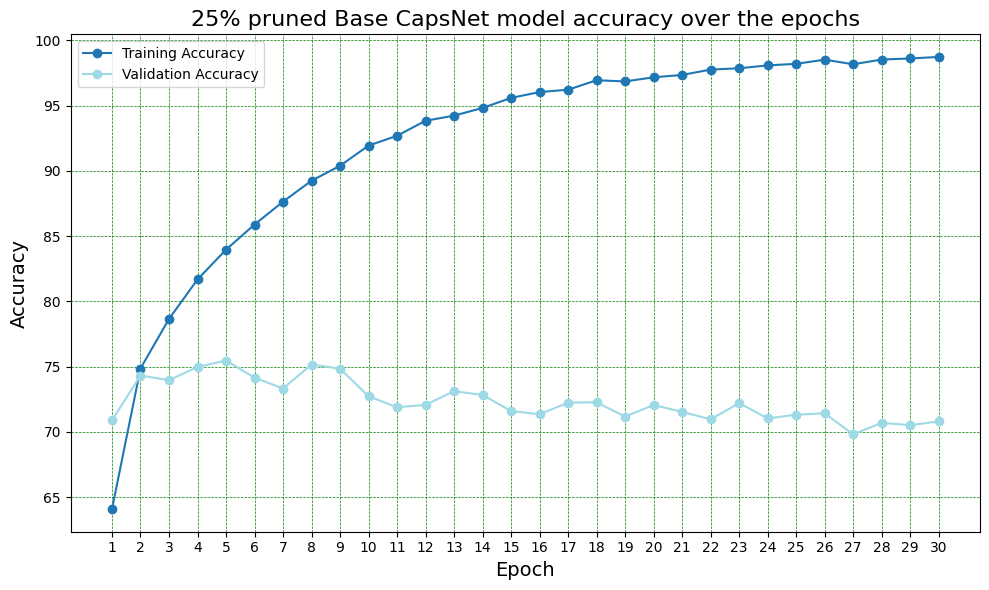

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% pruned Base CapsNet model accuracy over the epochs')

In [ ]:
# print("training is complete")

# time.sleep(10)
# print("Unassigning runtime")

# from google.colab import runtime
# runtime.unassign()

training is complete


#### 37.5% Pruning

In [ ]:
prune_threshold = 0.375

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_37pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_37pc_base_capsnet_cifar10_model.name = 'pruned_37pc_base_capsnet_cifar10_model'
pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 36, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(36, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(60, 60, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_37pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_37pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/10 09:04:23 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5555, Top 1 Acc=17.19, Top 5 Acc=51.56
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5555, Top 1 Acc=17.19, Top 5 Acc=51.56
02/10 09:04:27 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4172, Top 1 Acc=40.67, Top 5 Acc=84.09
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4172, Top 1 Acc=40.67, Top 5 Acc=84.09
02/10 09:04:31 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3721, Top 1 Acc=49.07, Top 5 Acc=88.41
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3721, Top 1 Acc=49.07, Top 5 Acc=88.41
02/10 09:04:37 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3502, Top 1 Acc=52.84, Top 5 Acc=90.28
INFO:

CPU times: user 28min 39s, sys: 1min 39s, total: 30min 18s
Wall time: 30min 38s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_accuracy']

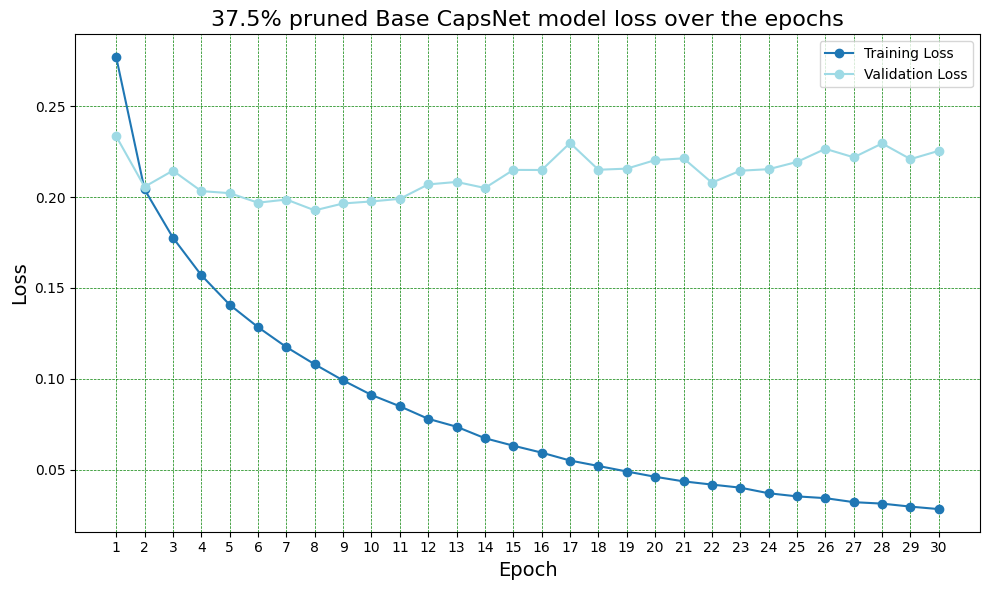

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% pruned Base CapsNet model loss over the epochs')

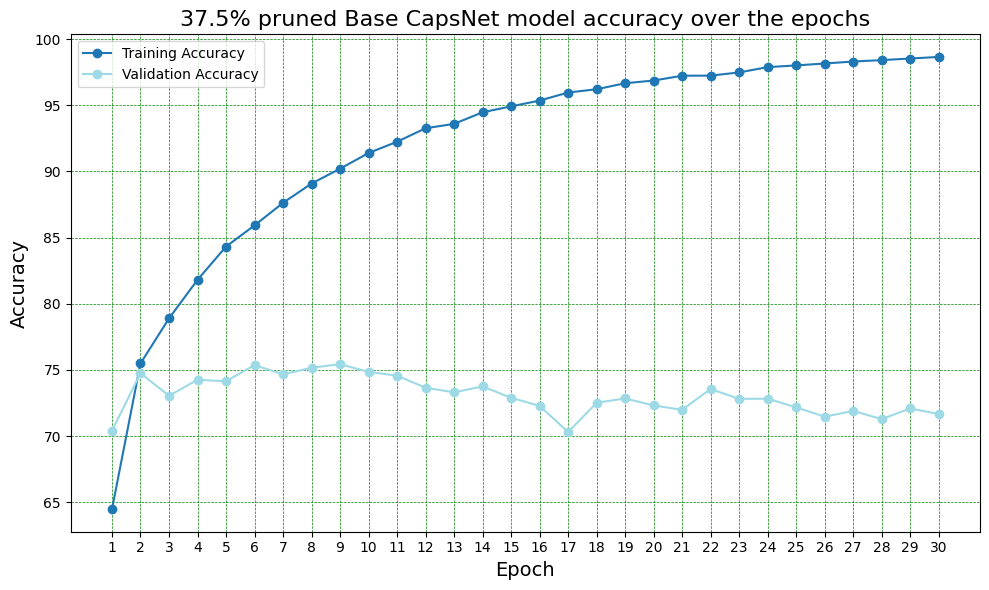

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% pruned Base CapsNet model accuracy over the epochs')

#### 50% Pruning

In [ ]:
prune_threshold = 0.50

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_50pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_50pc_base_capsnet_cifar10_model.name = 'pruned_50pc_base_capsnet_cifar10_model'
pruned_50pc_base_capsnet_cifar10_model = pruned_50pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_50pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_50pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/10 09:35:00 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5387, Top 1 Acc=10.94, Top 5 Acc=54.69
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5387, Top 1 Acc=10.94, Top 5 Acc=54.69
02/10 09:35:05 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.3998, Top 1 Acc=43.03, Top 5 Acc=87.14
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.3998, Top 1 Acc=43.03, Top 5 Acc=87.14
02/10 09:35:10 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3644, Top 1 Acc=49.53, Top 5 Acc=89.87
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3644, Top 1 Acc=49.53, Top 5 Acc=89.87
02/10 09:35:14 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3447, Top 1 Acc=52.77, Top 5 Acc=91.38
INFO:

CPU times: user 27min 58s, sys: 1min 39s, total: 29min 38s
Wall time: 29min 52s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_accuracy']

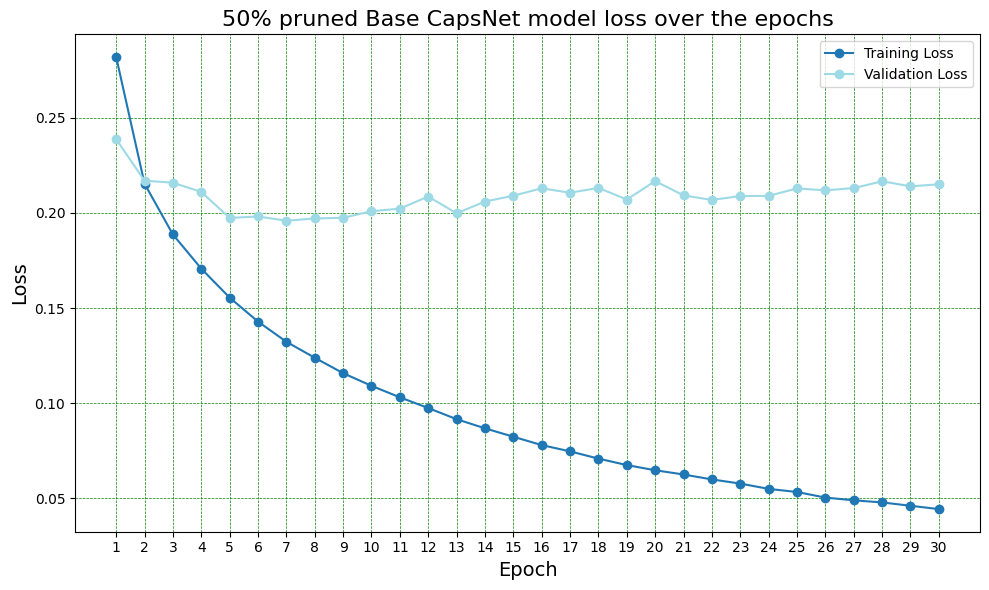

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '50% pruned Base CapsNet model loss over the epochs')

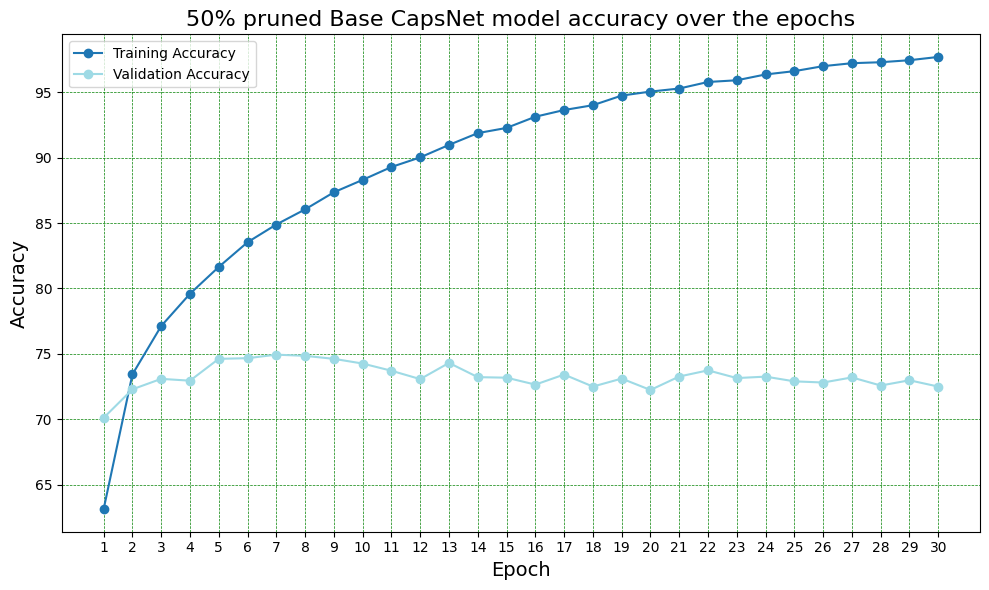

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '50% pruned Base CapsNet model accuracy over the epochs')

#### 62.5% Pruning

In [ ]:
prune_threshold = 0.625

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_62pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_62pc_base_capsnet_cifar10_model.name = 'pruned_62pc_base_capsnet_cifar10_model'
pruned_62pc_base_capsnet_cifar10_model = pruned_62pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(36, 36, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_62pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_62pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/10 11:47:56 PM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5701, Top 1 Acc=14.06, Top 5 Acc=57.81
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5701, Top 1 Acc=14.06, Top 5 Acc=57.81
02/10 11:48:01 PM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4063, Top 1 Acc=41.56, Top 5 Acc=85.70
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4063, Top 1 Acc=41.56, Top 5 Acc=85.70
02/10 11:48:04 PM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3684, Top 1 Acc=48.69, Top 5 Acc=89.26
INFO:capsnet:pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3684, Top 1 Acc=48.69, Top 5 Acc=89.26
02/10 11:48:11 PM | pruned_62pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3469, Top 1 Acc=52.35, Top 5 Acc=90.77
INFO:

CPU times: user 24min 48s, sys: 1min 30s, total: 26min 19s
Wall time: 26min 44s


#####Plots for losses and accuracies

In [ ]:
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_62pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_62pc_base_capsnet_cifar10_model['epoch_accuracy']

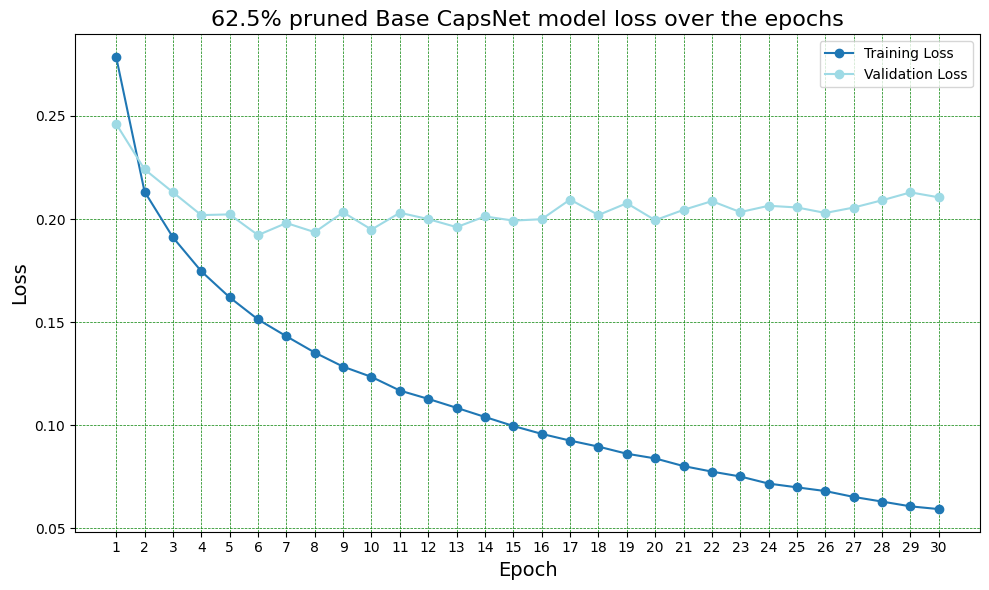

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '62.5% pruned Base CapsNet model loss over the epochs')

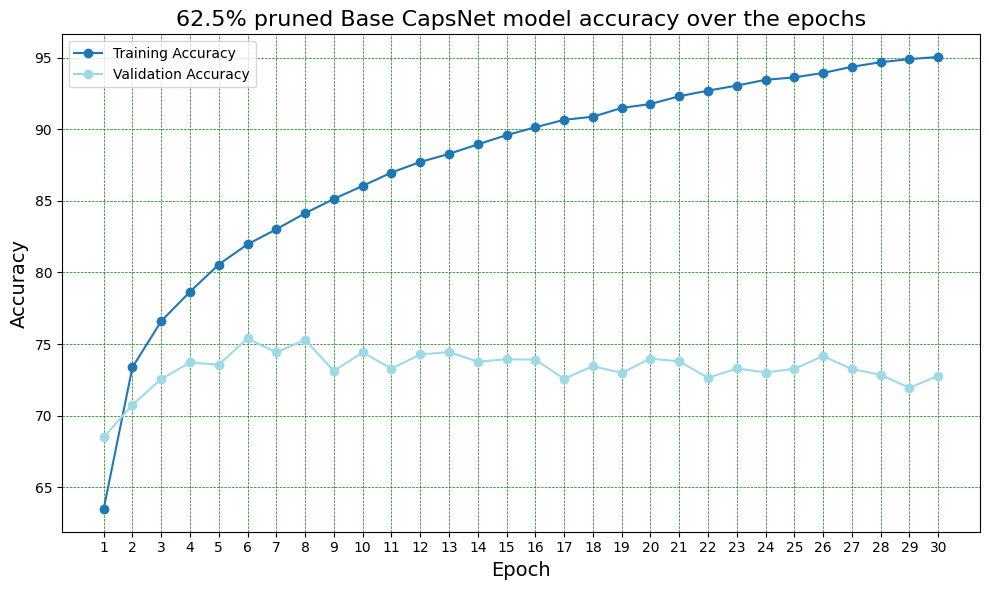

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '62.5% pruned Base CapsNet model accuracy over the epochs')

#### 75% Pruning

In [ ]:
prune_threshold = 0.75

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_75pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_75pc_base_capsnet_cifar10_model.name = 'pruned_75pc_base_capsnet_cifar10_model'
pruned_75pc_base_capsnet_cifar10_model = pruned_75pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer()
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_75pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_75pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/10 10:35:03 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6473, Top 1 Acc=9.38, Top 5 Acc=37.50
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6473, Top 1 Acc=9.38, Top 5 Acc=37.50
02/10 10:35:07 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4448, Top 1 Acc=34.54, Top 5 Acc=81.08
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4448, Top 1 Acc=34.54, Top 5 Acc=81.08
02/10 10:35:12 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3984, Top 1 Acc=42.72, Top 5 Acc=86.57
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3984, Top 1 Acc=42.72, Top 5 Acc=86.57
02/10 10:35:16 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3753, Top 1 Acc=46.62, Top 5 Acc=88.77
INFO:ca

CPU times: user 26min 36s, sys: 1min 40s, total: 28min 16s
Wall time: 28min 29s


#####Plots for losses and accuracies

In [ ]:
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_accuracy']

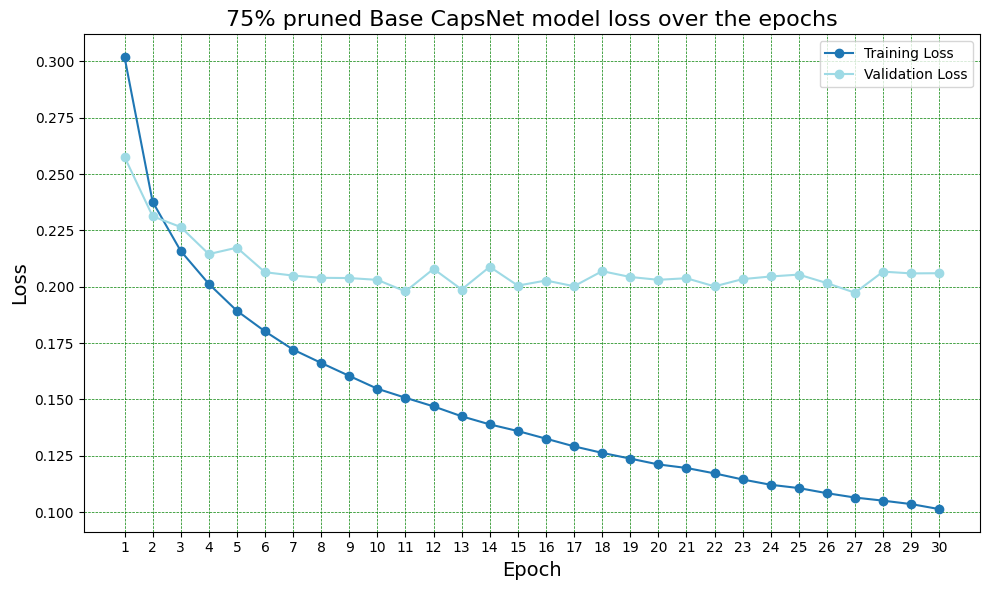

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '75% pruned Base CapsNet model loss over the epochs')

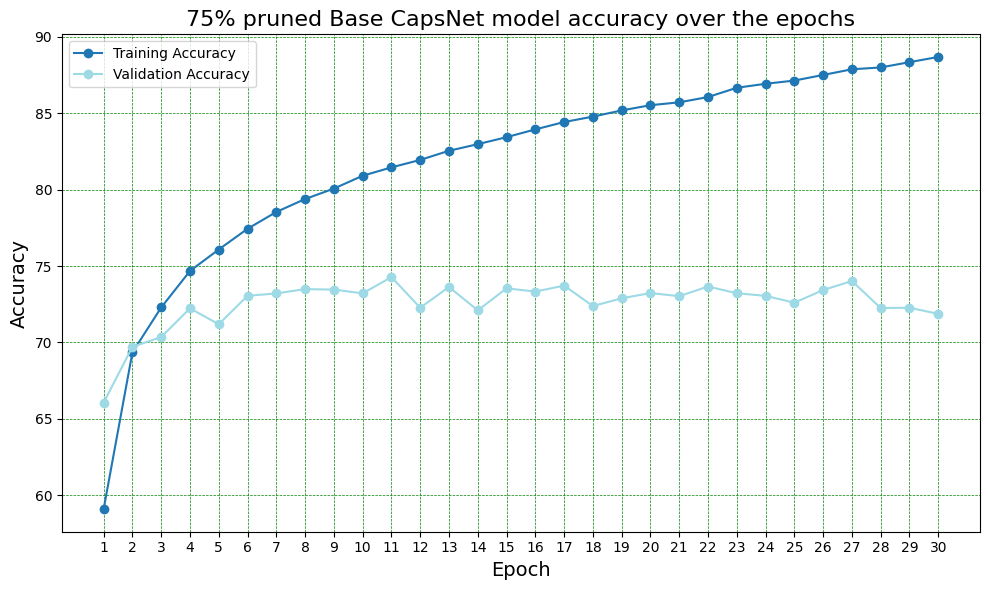

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '75% pruned Base CapsNet model accuracy over the epochs')

#### Plots for Unpruned and Pruned CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/8Caps12Dim/"

trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_62pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_62pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_62pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 30

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][1]

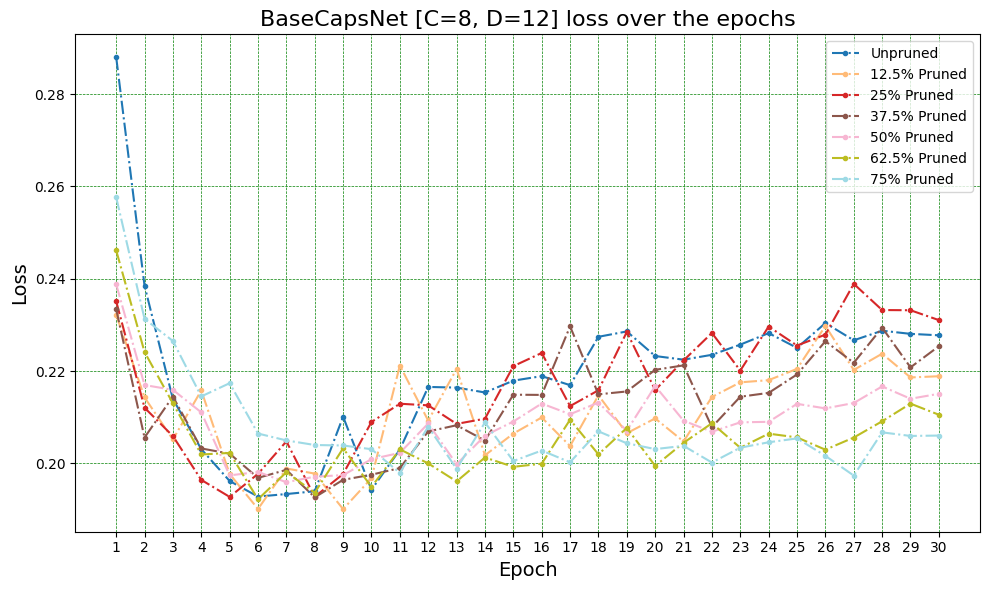

In [ ]:
utils.plot_line_chart(epoch_losses, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '62.5% Pruned', '75% Pruned'],
                      'Epoch', 'Loss', 'BaseCapsNet [C=8, D=12] loss over the epochs', marker='.', line='-.')

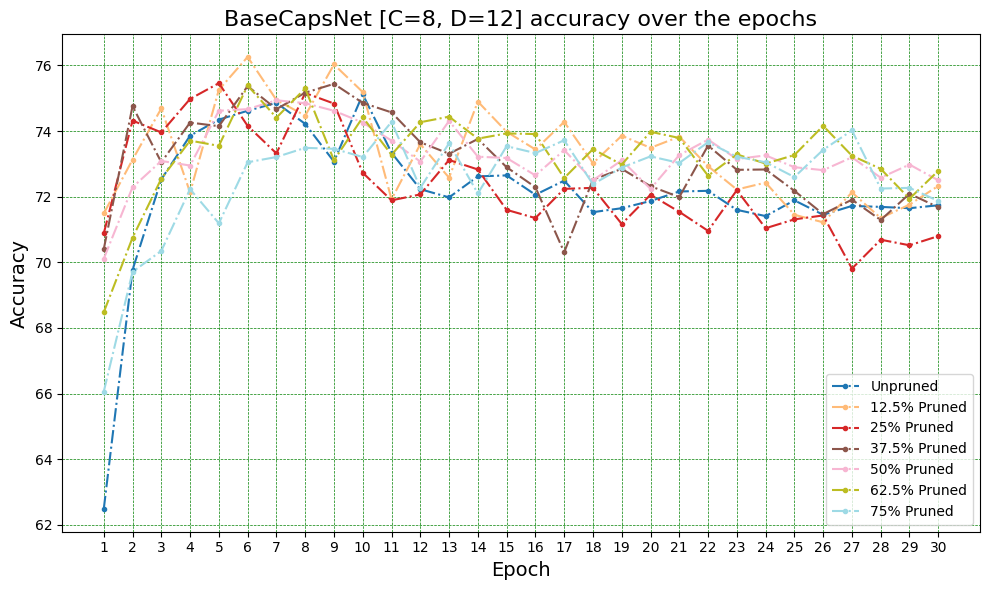

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '62.5% Pruned', '75% Pruned'],
                      'Epoch', 'Accuracy', 'BaseCapsNet [C=8, D=12] accuracy over the epochs', marker='.', line='-.')

#### Flops and Params Count

In [ ]:
def count_class_caps_ops(m, x, y: torch.Tensor):
    x = x[0]
    x = x.view(x.size(0), x.size(1), 1, x.size(2), 1)

    count_mat = vision.calc_func.counter_matmul(m.weights.shape, x.shape)
    m.total_ops += count_mat

In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)

custom_ops = {caps.CapsLayer : count_class_caps_ops}

In [ ]:
base_capsnet_cifar10_model.eval()

flops, params = profile(base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 Flops = {}".format(base_capsnet_cifar10_model.name, flops))
print("{} CIFAR10 Params = {}".format(base_capsnet_cifar10_model.name, params))

base_capsnet_cifar10_model CIFAR10 Flops = 18.997M
base_capsnet_cifar10_model CIFAR10 Params = 888.504K


In [ ]:
prune_threshold = 0.125
pruned_12pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_12pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Flops = 12.237M
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Params = 753.840K


In [ ]:
prune_threshold = 0.25
pruned_25pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_25pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Flops = 10.309M
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Params = 638.988K


In [ ]:
prune_threshold = 0.375
pruned_37pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_37pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Flops = 8.509M
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Params = 526.728K


In [ ]:
prune_threshold = 0.50
pruned_50pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_50pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Flops = 5.165M
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Params = 410.556K


In [ ]:
prune_threshold = 0.625
pruned_62pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_62pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_62pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_62pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_62pc_base_capsnet_cifar10_model CIFAR10 62.5% pruned Flops = 3.950M
pruned_62pc_base_capsnet_cifar10_model CIFAR10 62.5% pruned Params = 304.776K


In [ ]:
prune_threshold = 0.75
pruned_75pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_75pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Flops = 1.855M
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Params = 197.676K
